In [188]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [189]:
def step(t, dt):
    t = t + dt
    return t

In [190]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [191]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [243]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0

        if self.view_max > end_row:
            self.view_max = end_row
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > self.view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind?
        if len(self.fruitBTree) > 0:
            self.passedFruit()
            
        self.i_lastFruit = j
        
    
    def passedFruit(self):  
        # removal of all smaller keys than the vehicle's edge from B-Tree
        edge_key  = math.ceil(self.view_min*1000) # edge being passed
        
        try: # if no key exists after the potential key, break out rather than crash the program
            max_key_pop = self.fruitBTree.maxKey(edge_key)
            
            for k in self.fruitBTree.keys():
                if k < max_key_pop:
                    # so it doesn'thave to go through the whole B-Tree
                    self.passed_fruit.append(self.fruitBTree.pop(k))
                else:
                    break         

        except ValueError:
#             print("*** No key smaller than the edge value, broke out of the if statement ***")
            return
            
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [244]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [245]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 4.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q[1],q[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = 1.
        self.a_max         = 10. 
        self.d_max         = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.q_a[0] < self.q_f[0]-0.001:  
#             print("")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)

#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0.
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
        if self.q_a[0] < self.q_f[0]-0.001:
            print(" ")
            print("RETRACTING")
            print("ARM:", self.n, "ROW:", self.row_n)
            print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
            print(" ")
            print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print(" ")
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [276]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [277]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 15.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

In [278]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.01])       # in m, constant velocity

qv0 = []
qv1 = []

In [279]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [280]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [281]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.]) 

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        q_a_new[0] = q_a[0]             # doesn't change right now
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [282]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
#     picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys
                
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000) #+2
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1 
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)
                        ### make sure there are available goals left in the b-tree at some point
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break

                ## look into B-Trees 
                ## https://ebrary.net/25936/computer_science/b-tree_organization
                ## https://cstack.github.io/db_tutorial/parts/part7.html

                ## what happens when there are gaps between trees/fruits => right now it would freeze? => maybe not...
                ## => right now they freeze when they hit that 

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)

#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a[0,0].x_edges_f[0]))
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 6.3 9.8678696059 0
start, end, start velocity: 6.0 5.3231695488 0
start, end, start velocity: 1.5 1.1919865482 0
 
X-axis, Ta: 0.1 Tv: 3.4678696058999994 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.5768304511999999 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.20801345179999994 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.9191284757 0
start, end, start velocity: 9.0 7.5732524703 0
start, end, start velocity: 1.5 1.4549112491 0
 
X-axis, Ta: 0.1 Tv: 3.519128475699999 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.3267475297 Td: 0.1
Z-axis, Ta: 0.06714815775581634 Tv: 0 Td: 0.06714815775581634
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -0.6714815775581634 -10.0 -10.0
 
start, end, start velocity: 6.3 9.0836432909 0
start, end, start velocity: 12.0 10.794768294 0
start, end, start velocity: 1.5 0.9577824011 0
 
X-axis, Ta: 0.1 Tv: 2.6836432908999996 Td: 0.1

start, end, start velocity: 6.3 9.1832572047 0
start, end, start velocity: 5.323169548799956 5.3361231247 0
start, end, start velocity: 1.1919865482 2.4580419336 0
 
X-axis, Ta: 0.1 Tv: 2.7832572047000004 Td: 0.1
Y-axis, Ta: 0.03599107653300264 Tv: 0 Td: 0.03599107653300264
Z-axis, Ta: 0.1 Tv: 1.1660553854 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3599107653300264 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.478024536900001 6.3 0
start, end, start velocity: 7.046513907300002 6.3 0
start, end, start velocity: 6.3 7.2417547198 0
start, end, start velocity: 11.513563913199997 11.6215871822 0
start, end, start velocity: 8.644071610900001 8.7566722664 0
 
X-axis, Ta: 0.1 Tv: 0.8417547198000005 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.008023269000003802 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.012600655499999641 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 9.3127395

start, end, start velocity: 8.442642843100002 6.3 0
start, end, start velocity: 6.840973736500001 6.3 0
start, end, start velocity: 6.3 7.1250329818 0
start, end, start velocity: 7.701042372997194 7.7197088781 0
start, end, start velocity: 8.407642724200002 8.3982626737 0
 
X-axis, Ta: 0.1 Tv: 0.7250329818000006 Td: 0.1
Y-axis, Ta: 0.0432047510151435 Tv: 0 Td: 0.0432047510151435
Z-axis, Ta: 0.030626868106292827 Tv: 0 Td: 0.030626868106292827
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.432047510151435 10.0 10.0
reached values, Z: -0.30626868106292826 -10.0 -10.0
 
start, end, start velocity: 6.3 9.8022614416 0
start, end, start velocity: 7.66066827045289 7.6895733945 0
start, end, start velocity: 0.7551588789000065 1.2384430043 0
 
X-axis, Ta: 0.1 Tv: 3.4022614416000008 Td: 0.1
Y-axis, Ta: 0.05376348579390135 Tv: 0 Td: 0.05376348579390135
Z-axis, Ta: 0.1 Tv: 0.38328412539999357 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5376348579390134 10.0 10.0
reached

start, end, start velocity: 8.511296445099607 6.3 0
start, end, start velocity: 8.139884216099677 6.3 0
start, end, start velocity: 6.300000000000258 7.9591916189 0
start, end, start velocity: 11.845471650578933 11.86567306 0
start, end, start velocity: 7.33490150930022 8.3858779232 0
 
X-axis, Ta: 0.1 Tv: 1.559191618899742 Td: 0.1
Y-axis, Ta: 0.04494597804149761 Tv: 0 Td: 0.04494597804149761
Z-axis, Ta: 0.1 Tv: 0.9509764138997806 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4494597804149761 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000000196 7.9028977053 0
start, end, start velocity: 6.164720677457029 6.1760569125 0
start, end, start velocity: 5.509165249899969 3.8238515345 0
 
X-axis, Ta: 0.1 Tv: 1.5028977052998038 Td: 0.1
Y-axis, Ta: 0.03366932586638895 Tv: 0 Td: 0.03366932586638895
Z-axis, Ta: 0.1 Tv: 1.5853137153999683 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.33669325866388944 10.0 10.0
reached values

start, end, start velocity: 7.886753043700275 6.3 0
start, end, start velocity: 6.3 7.0966438283 0
start, end, start velocity: 7.905057182652356 7.9080927274 0
start, end, start velocity: 7.543520400900023 6.7278775249 0
 
X-axis, Ta: 0.1 Tv: 0.6966438283000006 Td: 0.1
Y-axis, Ta: 0.017422814777308525 Tv: 0 Td: 0.017422814777308525
Z-axis, Ta: 0.1 Tv: 0.7156428760000232 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.17422814777308526 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.0272386472 0
start, end, start velocity: 7.839013500913407 7.9743428698 0
start, end, start velocity: 1.0355144948001322 1.3078703716 0
 
X-axis, Ta: 0.1 Tv: 2.627238647200001 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.035329368886592855 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.17235587679986772 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 10.338714525599965 6.3 0
start, end, start velocity

start, end, start velocity: 6.3 8.8883629493 0
start, end, start velocity: 8.070708325300528 8.0722593184 0
start, end, start velocity: 4.855193355692245 3.8445091714 0
 
X-axis, Ta: 0.1 Tv: 2.4883629492999995 Td: 0.1
Y-axis, Ta: 0.012453887342805135 Tv: 0 Td: 0.012453887342805135
Z-axis, Ta: 0.1 Tv: 0.9106841842922454 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.12453887342805135 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.713257029600075 6.3 0
start, end, start velocity: 10.324618167400718 6.3 0
start, end, start velocity: 6.891528986900107 6.3 0
start, end, start velocity: 6.3 6.9522710835 0
start, end, start velocity: 8.099082786100022 8.1067254472 0
start, end, start velocity: 8.516690254500219 7.4776461589 0
 
X-axis, Ta: 0.1 Tv: 0.5522710835000005 Td: 0.1
Y-axis, Ta: 0.027645363263988608 Tv: 0 Td: 0.027645363263988608
Z-axis, Ta: 0.1 Tv: 0.939044095600219 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.27645363

start, end, start velocity: 8.794120337200445 6.3 0
start, end, start velocity: 9.864726986100635 6.3 0
start, end, start velocity: 6.3 7.886888742 0
start, end, start velocity: 6.443033287234031 6.4448659217 0
start, end, start velocity: 3.1146068911996565 5.5263766939 0
 
X-axis, Ta: 0.1 Tv: 1.486888742 Td: 0.1
Y-axis, Ta: 0.013537483022958624 Tv: 0 Td: 0.013537483022958624
Z-axis, Ta: 0.1 Tv: 2.311769802700343 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.13537483022958624 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 9.0814318178 0
start, end, start velocity: 5.576770374992545 5.5834833471 0
start, end, start velocity: 1.398744092664764 2.2953723737 0
 
X-axis, Ta: 0.1 Tv: 2.6814318178000005 Td: 0.1
Y-axis, Ta: 0.02590940390563697 Tv: 0 Td: 0.02590940390563697
Z-axis, Ta: 0.1 Tv: 0.7966282810352358 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2590940390563697 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end,

start, end, start velocity: 7.658086215200242 6.3 0
start, end, start velocity: 7.939201221700292 6.3 0
start, end, start velocity: 7.148559882300151 6.3 0
start, end, start velocity: 6.3 8.4445107683 0
start, end, start velocity: 11.441094347009829 11.4653766382 0
start, end, start velocity: 2.2034800307003284 2.2924537171 0
 
X-axis, Ta: 0.1 Tv: 2.044510768300001 Td: 0.1
Y-axis, Ta: 0.049277064837682745 Tv: 0 Td: 0.049277064837682745
Z-axis, Ta: 0.09432586410930541 Tv: 0 Td: 0.09432586410930541
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.49277064837682744 10.0 10.0
reached values, Z: 0.9432586410930541 10.0 10.0
 
start, end, start velocity: 6.3 8.5567195037 0
start, end, start velocity: 11.351465754137951 11.3623173569 0
start, end, start velocity: 3.215184798243601 3.1303465072 0
 
X-axis, Ta: 0.1 Tv: 2.1567195037 Td: 0.1
Y-axis, Ta: 0.03294177099375333 Tv: 0 Td: 0.03294177099375333
Z-axis, Ta: 0.09210770382742192 Tv: 0 Td: 0.09210770382742192
 
reached values, X: 1.0 1

start, end, start velocity: 9.795019148498138 6.3 0
start, end, start velocity: 6.3000000000008285 7.7657539526 0
start, end, start velocity: 11.403387145230779 11.4125392622 0
start, end, start velocity: 5.270658804898857 5.2880447138 0
 
X-axis, Ta: 0.1 Tv: 1.3657539525991713 Td: 0.1
Y-axis, Ta: 0.030252465964314974 Tv: 0 Td: 0.030252465964314974
Z-axis, Ta: 0.041696413396289586 Tv: 0 Td: 0.041696413396289586
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.30252465964314973 10.0 10.0
reached values, Z: 0.4169641339628959 10.0 10.0
 
start, end, start velocity: 7.783642699399208 6.3 0
start, end, start velocity: 6.3000000000006375 6.7368066887 0
start, end, start velocity: 8.558179359303706 8.6387930685 0
start, end, start velocity: 6.70131606730085 7.7587742128 0
 
X-axis, Ta: 0.1 Tv: 0.33680668869936226 Td: 0.1
Y-axis, Ta: 0.0897851375208025 Tv: 0 Td: 0.0897851375208025
Z-axis, Ta: 0.1 Tv: 0.9574581454991501 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.897

start, end, start velocity: 7.72044669289924 6.3 0
start, end, start velocity: 6.300000000001095 8.9775639157 0
start, end, start velocity: 11.502344207024345 11.5329733137 0
start, end, start velocity: 2.4442000137992768 1.9556398422 0
 
X-axis, Ta: 0.1 Tv: 2.5775639156989043 Td: 0.1
Y-axis, Ta: 0.05534356934247585 Tv: 0 Td: 0.05534356934247585
Z-axis, Ta: 0.1 Tv: 0.3885601715992767 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5534356934247585 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.300000000001862 9.7746217813 0
start, end, start velocity: 5.8026858963999235 5.8285859145 0
start, end, start velocity: 1.3457282395005492 0.855563029 0
 
X-axis, Ta: 0.1 Tv: 3.374621781298138 Td: 0.1
Y-axis, Ta: 0.05089206038281034 Tv: 0 Td: 0.05089206038281034
Z-axis, Ta: 0.1 Tv: 0.3901652105005492 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5089206038281034 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velo

start, end, start velocity: 6.300000000000627 7.6536451527 0
start, end, start velocity: 8.81706040006119 8.8352068058 0
start, end, start velocity: 6.340165724700883 7.7034804995 0
 
X-axis, Ta: 0.1 Tv: 1.2536451526993733 Td: 0.1
Y-axis, Ta: 0.042598598261927835 Tv: 0 Td: 0.042598598261927835
Z-axis, Ta: 0.1 Tv: 1.2633147747991171 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.42598598261927834 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.30000000000093 7.5264664522 0
start, end, start velocity: 6.6550566176407076 6.6765618552 0
start, end, start velocity: 4.340675944000393 5.4654702567 0
 
X-axis, Ta: 0.1 Tv: 1.1264664521990704 Td: 0.1
Y-axis, Ta: 0.04637373993899195 Tv: 0 Td: 0.04637373993899195
Z-axis, Ta: 0.1 Tv: 1.024794312699607 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4637373993899195 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000000706 7.8381145569 0
start, end, start ve

start, end, start velocity: 7.382310580399421 6.3 0
start, end, start velocity: 8.19108319959899 6.3 0
start, end, start velocity: 6.300000000000578 8.9316400529 0
start, end, start velocity: 6.828968869009865 6.9349858264 0
start, end, start velocity: 4.886329767721433 3.2037392575 0
 
X-axis, Ta: 0.1 Tv: 2.5316400528994225 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.006016957390135497 Td: 0.1
Z-axis, Ta: 0.1 Tv: 1.5825905102214328 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 7.685939169299261 6.3 0
start, end, start velocity: 7.048349777299603 6.3 0
start, end, start velocity: 7.284909641699474 6.3 0
start, end, start velocity: 6.300000000001313 8.2585472118 0
start, end, start velocity: 11.575879039828989 11.5837906398 0
start, end, start velocity: 2.9474407941992142 2.262073745 0
 
X-axis, Ta: 0.1 Tv: 1.8585472117986863 Td: 0.1
Y-axis, Ta: 0.028127566498030963 Tv: 0 Td: 0.028127566498030963
Z-axis, T

start, end, start velocity: 7.10978695399957 6.3 0
start, end, start velocity: 9.776153542498147 6.3 0
start, end, start velocity: 6.300000000000904 8.0655797807 0
start, end, start velocity: 8.574770583793256 8.5897312792 0
start, end, start velocity: 5.213097924899724 4.9481375298 0
 
X-axis, Ta: 0.1 Tv: 1.6655797806990962 Td: 0.1
Y-axis, Ta: 0.03867905816684793 Tv: 0 Td: 0.03867905816684793
Z-axis, Ta: 0.1 Tv: 0.1649603950997239 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.38679058166847924 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.995893479499629 6.3 0
start, end, start velocity: 7.981102036799102 6.3 0
start, end, start velocity: 6.300000000000691 7.5477833266 0
start, end, start velocity: 9.25285430386535 9.2919107283 0
start, end, start velocity: 6.563668193800174 7.5278985393 0
 
X-axis, Ta: 0.1 Tv: 1.1477833265993094 Td: 0.1
Y-axis, Ta: 0.06249513935871304 Tv: 0 Td: 0.06249513935871304
Z-axis, Ta: 0.1 Tv: 0.864230345499825

 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6756429085946516 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.092838534399045 6.3 0
start, end, start velocity: 6.300000000000584 6.8541647819 0
start, end, start velocity: 9.46094242875758 9.6086976668 0
start, end, start velocity: 7.546887672399368 6.305748844 0
 
X-axis, Ta: 0.1 Tv: 0.45416478189941556 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.04775523804241963 Td: 0.1
Z-axis, Ta: 0.1 Tv: 1.141138828399368 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.30000000000044 7.2025274 0
start, end, start velocity: 12.68680149907112 12.6993695422 0
start, end, start velocity: 6.962693425300829 8.5572339296 0
 
X-axis, Ta: 0.1 Tv: 0.8025273999995598 Td: 0.1
Y-axis, Ta: 0.03545143597779917 Tv: 0 Td: 0.03545143597779917
Z-axis, Ta: 0.1 Tv: 1.4945405042991715 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.35

start, end, start velocity: 6.300000000000483 6.3979290928 0
start, end, start velocity: 9.81421627552569 9.8386384547 0
start, end, start velocity: 8.103483951032265 6.8122172551 0
 
X-axis, Ta: 0.09895912934111592 Tv: 0 Td: 0.09895912934111592
Y-axis, Ta: 0.04941880125449265 Tv: 0 Td: 0.04941880125449265
Z-axis, Ta: 0.1 Tv: 1.1912666959322649 Td: 0.1
 
reached values, X: 0.9895912934111593 10.0 10.0
reached values, Y: 0.4941880125449265 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 7.159033584199595 6.3 0
start, end, start velocity: 6.300000000000171 8.7878274632 0
start, end, start velocity: 8.784118685022353 8.8226369836 0
start, end, start velocity: 4.853053452288718 4.3690321429 0
 
X-axis, Ta: 0.1 Tv: 2.387827463199828 Td: 0.1
Y-axis, Ta: 0.0620631118923695 Tv: 0 Td: 0.0620631118923695
Z-axis, Ta: 0.1 Tv: 0.3840213093887176 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.620631118923695 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 

start, end, start velocity: 8.164999999999912 6.3 0
start, end, start velocity: 6.3 7.9208771576 0
start, end, start velocity: 7.307427467823404 7.3081255577 0
start, end, start velocity: 3.218841228899234 3.2540050919 0
 
X-axis, Ta: 0.1 Tv: 1.5208771575999998 Td: 0.1
Y-axis, Ta: 0.008355177296722655 Tv: 0 Td: 0.008355177296722655
Z-axis, Ta: 0.05929912562657715 Tv: 0 Td: 0.05929912562657715
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.08355177296722656 10.0 10.0
reached values, Z: 0.5929912562657715 10.0 10.0
 
start, end, start velocity: 6.85382358510049 6.3 0
start, end, start velocity: 6.3 6.5117638931 0
start, end, start velocity: 10.03842800520012 10.0422090517 0
start, end, start velocity: 6.024445824699873 6.8347155844 0
 
X-axis, Ta: 0.1 Tv: 0.11176389310000054 Td: 0.1
Y-axis, Ta: 0.01944491321626639 Tv: 0 Td: 0.01944491321626639
Z-axis, Ta: 0.1 Tv: 0.7102697597001267 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.1944491321626639 10.0 10.0
reached

start, end, start velocity: 7.553344424501112 6.3 0
start, end, start velocity: 6.3 6.8901515847 0
start, end, start velocity: 10.113138961096205 10.1627814142 0
start, end, start velocity: 6.131513806448706 6.9574079167 0
 
X-axis, Ta: 0.1 Tv: 0.4901515847000001 Td: 0.1
Y-axis, Ta: 0.07045740067856243 Tv: 0 Td: 0.07045740067856243
Z-axis, Ta: 0.1 Tv: 0.7258941102512942 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7045740067856243 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 7.337913175400916 6.3 0
start, end, start velocity: 6.3 7.4099530097 0
start, end, start velocity: 11.956589545393019 11.9726882126 0
start, end, start velocity: 3.602579210399546 5.0885980543 0
 
X-axis, Ta: 0.1 Tv: 1.0099530096999998 Td: 0.1
Y-axis, Ta: 0.04012314445177586 Tv: 0 Td: 0.04012314445177586
Z-axis, Ta: 0.1 Tv: 1.386018843900454 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4012314445177586 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
sta

start, end, start velocity: 6.3 8.7004592537 0
start, end, start velocity: 9.083783371567952 9.1497875373 0
start, end, start velocity: 5.213067199601628 3.5195082344 0
 
X-axis, Ta: 0.1 Tv: 2.3004592537 Td: 0.1
Y-axis, Ta: 0.08124294783674953 Tv: 0 Td: 0.08124294783674953
Z-axis, Ta: 0.1 Tv: 1.5935589652016282 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8124294783674952 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 8.8235095894 0
start, end, start velocity: 12.049227258320359 12.0860941097 0
start, end, start velocity: 4.555722281599517 4.1891925649 0
 
X-axis, Ta: 0.1 Tv: 2.4235095894000005 Td: 0.1
Y-axis, Ta: 0.06071807916892662 Tv: 0 Td: 0.06071807916892662
Z-axis, Ta: 0.1 Tv: 0.2665297166995174 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6071807916892662 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.594112674402036 6.3 0
start, end, start velocity: 8.628049276102065 6.3 0
star

start, end, start velocity: 6.3 9.3413817931 0
start, end, start velocity: 8.925993247773299 8.9765928918 0
start, end, start velocity: 3.347634482500137 3.239231916 0
 
X-axis, Ta: 0.1 Tv: 2.9413817931 Td: 0.1
Y-axis, Ta: 0.0711334267603498 Tv: 0 Td: 0.0711334267603498
Z-axis, Ta: 0.1 Tv: 0.008402566500136904 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7113342676034979 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 7.590501366701148 6.3 0
start, end, start velocity: 7.57677221080113 6.3 0
start, end, start velocity: 6.3 8.77675608 0
start, end, start velocity: 6.358540871700087 6.3844316284 0
start, end, start velocity: 2.6978234513688553 2.083781635 0
 
X-axis, Ta: 0.1 Tv: 2.3767560800000003 Td: 0.1
Y-axis, Ta: 0.05088296050733774 Tv: 0 Td: 0.05088296050733774
Z-axis, Ta: 0.1 Tv: 0.5140418163688555 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5088296050733774 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end

start, end, start velocity: 7.937031487401449 6.3 0
start, end, start velocity: 6.3 7.0960630193 0
start, end, start velocity: 13.604897692592901 13.6250874638 0
start, end, start velocity: 7.194535413598931 6.3326771283 0
 
X-axis, Ta: 0.1 Tv: 0.6960630193 Td: 0.1
Y-axis, Ta: 0.04493302928481276 Tv: 0 Td: 0.04493302928481276
Z-axis, Ta: 0.1 Tv: 0.761858285298931 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.44933029284812764 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 7.646122358001192 6.3 0
start, end, start velocity: 6.3 9.3919441802 0
start, end, start velocity: 6.528397661405049 6.591081971 0
start, end, start velocity: 2.801502242729372 2.8589673487 0
 
X-axis, Ta: 0.1 Tv: 2.9919441801999995 Td: 0.1
Y-axis, Ta: 0.07917342331549862 Tv: 0 Td: 0.07917342331549862
Z-axis, Ta: 0.07580574250716625 Tv: 0 Td: 0.07580574250716625
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7917342331549863 10.0 10.0
reached values, Z: 0.7580574

start, end, start velocity: 6.3 8.3949681995 0
start, end, start velocity: 9.62359274644194 9.7243250338 0
start, end, start velocity: 2.0720212784003174 2.8343975937 0
 
X-axis, Ta: 0.1 Tv: 1.9949681994999993 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.0007322873580598299 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.6623763152996825 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 7.7963013184013255 6.3 0
start, end, start velocity: 6.3 8.4322782678 0
start, end, start velocity: 10.28764849692085 10.291801695 0
start, end, start velocity: 5.078083982399864 3.7583417765 0
 
X-axis, Ta: 0.1 Tv: 2.0322782677999993 Td: 0.1
Y-axis, Ta: 0.020379396652379197 Tv: 0 Td: 0.020379396652379197
Z-axis, Ta: 0.1 Tv: 1.219742205899864 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.20379396652379198 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.080222954202473 6.3 0
start, end, start velocity:

start, end, start velocity: 6.3 8.5924638941 0
start, end, start velocity: 9.834694942400093 9.8395061481 0
start, end, start velocity: 2.0662982936993233 2.9819487871 0
 
X-axis, Ta: 0.1 Tv: 2.1924638941 Td: 0.1
Y-axis, Ta: 0.02193446078641325 Tv: 0 Td: 0.02193446078641325
Z-axis, Ta: 0.1 Tv: 0.8156504934006766 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2193446078641325 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 8.6086864329 0
start, end, start velocity: 12.913955179419245 12.9242361912 0
start, end, start velocity: 5.438321826300322 4.002066264 0
 
X-axis, Ta: 0.1 Tv: 2.208686432900001 Td: 0.1
Y-axis, Ta: 0.03206401687367792 Tv: 0 Td: 0.03206401687367792
Z-axis, Ta: 0.1 Tv: 1.3362555623003218 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3206401687367792 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 8.5208542771 0
start, end, start velocity: 10.347507718464051 10.3747948921 0
st

start, end, start velocity: 6.3 7.6613105293 0
start, end, start velocity: 13.955813074985679 14.3261005607 0
start, end, start velocity: 7.253394267000207 7.3557085059 0
 
X-axis, Ta: 0.1 Tv: 1.2613105292999998 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.2702874857143215 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.0023142388997930696 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 7.9711313840014855 6.3 0
start, end, start velocity: 8.676355134602106 6.3 0
start, end, start velocity: 8.696947304102126 6.3 0
start, end, start velocity: 8.64331745220208 6.3 0
start, end, start velocity: 8.394999999999907 6.3 0
start, end, start velocity: 6.3 8.123844152 0
start, end, start velocity: 10.733674063100208 11.9377087642 0
start, end, start velocity: 3.5875282154004635 4.6984102677 0
 
X-axis, Ta: 0.1 Tv: 1.7238441520000003 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.1040347010997915 Td: 0.1
Z-axis, Ta: 0.1 Tv: 1.0108820522995363 Td: 0.1
 
reac

start, end, start velocity: 9.65242218070298 6.3 0
start, end, start velocity: 7.967424381701476 6.3 0
start, end, start velocity: 6.3 7.7247303114 0
start, end, start velocity: 13.133366575023063 13.2112999291 0
start, end, start velocity: 4.113389909599626 4.9674553176 0
 
X-axis, Ta: 0.1 Tv: 1.3247303114000002 Td: 0.1
Y-axis, Ta: 0.08827986977614899 Tv: 0 Td: 0.08827986977614899
Z-axis, Ta: 0.1 Tv: 0.7540654080003742 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8827986977614899 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 7.510638743301077 6.3 0
start, end, start velocity: 9.620187487202951 6.3 0
start, end, start velocity: 6.3 6.683181092 0
start, end, start velocity: 14.38906680856438 14.4367225297 0
start, end, start velocity: 7.309181588000634 7.8649483297 0
 
X-axis, Ta: 0.1 Tv: 0.2831810920000001 Td: 0.1
Y-axis, Ta: 0.06903312330730896 Tv: 0 Td: 0.06903312330730896
Z-axis, Ta: 0.1 Tv: 0.45576674169936615 Td: 0.1
 
reached values, 

start, end, start velocity: 9.027578127802418 6.3 0
start, end, start velocity: 6.3 7.4248254954 0
start, end, start velocity: 14.587011341209816 14.6154723908 0
start, end, start velocity: 7.9017935757010065 7.1707222153 0
 
X-axis, Ta: 0.1 Tv: 1.0248254954000005 Td: 0.1
Y-axis, Ta: 0.0533488983861752 Tv: 0 Td: 0.0533488983861752
Z-axis, Ta: 0.1 Tv: 0.6310713604010069 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.533488983861752 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 8.761382837 0
start, end, start velocity: 10.36539842502757 10.3801915062 0
start, end, start velocity: 0.49819284119903506 0.5673132055 0
 
X-axis, Ta: 0.1 Tv: 2.3613828369999994 Td: 0.1
Y-axis, Ta: 0.038461774754202024 Tv: 0 Td: 0.038461774754202024
Z-axis, Ta: 0.08313865785599675 Tv: 0 Td: 0.08313865785599675
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.38461774754202027 10.0 10.0
reached values, Z: 0.8313865785599676 10.0 10.0
 
start, end, start ve

start, end, start velocity: 6.3 9.1194441258 0
start, end, start velocity: 7.8121918859002015 7.8275337152 0
start, end, start velocity: 0.616411164298174 1.2266952883 0
 
X-axis, Ta: 0.1 Tv: 2.7194441257999995 Td: 0.1
Y-axis, Ta: 0.039168647282997765 Tv: 0 Td: 0.039168647282997765
Z-axis, Ta: 0.1 Tv: 0.510284124001826 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.39168647282997765 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 8.6850016568 0
start, end, start velocity: 13.537931881005289 13.5542748908 0
start, end, start velocity: 3.6634634440980527 3.492469706 0
 
X-axis, Ta: 0.1 Tv: 2.285001656800001 Td: 0.1
Y-axis, Ta: 0.0404264885869546 Tv: 0 Td: 0.0404264885869546
Z-axis, Ta: 0.1 Tv: 0.07099373809805262 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.404264885869546 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 8.4507430051 0
start, end, start velocity: 11.672502808936914 11.73085917

start, end, start velocity: 6.3 8.7377759552 0
start, end, start velocity: 13.739409585961099 13.746157924 0
start, end, start velocity: 2.940143379552348 1.3432755943 0
 
X-axis, Ta: 0.1 Tv: 2.3377759552 Td: 0.1
Y-axis, Ta: 0.02597756347100654 Tv: 0 Td: 0.02597756347100654
Z-axis, Ta: 0.1 Tv: 1.496867785252348 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.25977563471006543 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.0958277948 0
start, end, start velocity: 8.31552862820012 9.5962872363 0
start, end, start velocity: 0.8625541377998727 1.6919217895 0
 
X-axis, Ta: 0.1 Tv: 2.6958277948 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.1807586080998802 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.7293676517001274 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 8.7005606911 0
start, end, start velocity: 13.746096124043708 13.7570978954 0
start, end, start velocity: 2.32514337

start, end, start velocity: 7.624999999999923 6.3 0
start, end, start velocity: 6.3 6.7895902543 0
start, end, start velocity: 14.942471700586161 14.945525816 0
start, end, start velocity: 7.920325270400296 8.5069379956 0
 
X-axis, Ta: 0.1 Tv: 0.3895902543000004 Td: 0.1
Y-axis, Ta: 0.017476027620254676 Tv: 0 Td: 0.017476027620254676
Z-axis, Ta: 0.1 Tv: 0.48661272519970356 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.17476027620254675 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 9.0166465417 0
start, end, start velocity: 14.003176219915066 14.0128743565 0
start, end, start velocity: 3.382262996359091 3.3740755394 0
 
X-axis, Ta: 0.1 Tv: 2.6166465417 Td: 0.1
Y-axis, Ta: 0.0311418313285102 Tv: 0 Td: 0.0311418313285102
Z-axis, Ta: 0.028613732645516483 Tv: 0 Td: 0.028613732645516483
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.311418313285102 10.0 10.0
reached values, Z: -0.2861373264551648 -10.0 -10.0
 
start, end, start velocit

start, end, start velocity: 7.719319617501255 6.3 0
start, end, start velocity: 9.335156608702695 6.3 0
start, end, start velocity: 6.3 7.3869473526 0
start, end, start velocity: 14.279090224873261 14.3222100199 0
start, end, start velocity: 4.977383292800801 4.9128888124 0
 
X-axis, Ta: 0.1 Tv: 0.9869473526000002 Td: 0.1
Y-axis, Ta: 0.0656656645643205 Tv: 0 Td: 0.0656656645643205
Z-axis, Ta: 0.0803084555951618 Tv: 0 Td: 0.0803084555951618
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.656656645643205 10.0 10.0
reached values, Z: -0.803084555951618 -10.0 -10.0
 
start, end, start velocity: 6.3 8.1652535807 0
start, end, start velocity: 14.283070958391802 14.3695778483 0
start, end, start velocity: 4.526571399444707 5.2079644787 0
 
X-axis, Ta: 0.1 Tv: 1.7652535807 Td: 0.1
Y-axis, Ta: 0.09300908015253062 Tv: 0 Td: 0.09300908015253062
Z-axis, Ta: 0.1 Tv: 0.5813930792552929 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.9300908015253062 10.0 10.0
reached values, 

start, end, start velocity: 9.517182503902854 6.3 0
start, end, start velocity: 7.665919079201211 6.3 0
start, end, start velocity: 8.644053045602082 6.3 0
start, end, start velocity: 6.3 8.5785999596 0
start, end, start velocity: 14.695640392602847 14.864640721 0
start, end, start velocity: 0.9381484727690218 1.4088787248 0
 
X-axis, Ta: 0.1 Tv: 2.1785999596 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.0690003283971535 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.3707302520309783 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 7.2571226594 0
start, end, start velocity: 14.565177407837524 14.6623866607 0
start, end, start velocity: 4.621435544099651 5.3592355652 0
 
X-axis, Ta: 0.1 Tv: 0.8571226594000004 Td: 0.1
Y-axis, Ta: 0.0985947528332392 Tv: 0 Td: 0.0985947528332392
Z-axis, Ta: 0.1 Tv: 0.6378000211003491 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.985947528332392 10.0 10.0
reached values, Z: 1.0 1

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

In [283]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
print("doesn't take into account that for a while there are no good targets")


program took: 14.872727155685425 sec
total internal time: 600.0099999995994
total vehicle distance moved: 8.700099999986016
total number of fruit in CSV file: 2638
total fruit reached for arm 0 is 76
total fruit reached for arm 1 is 108
total fruit reached for arm 2 is 98
total fruit reached for arm 0 is 89
total fruit reached for arm 1 is 151
total fruit reached for arm 2 is 158
total fruit reached for arm 0 is 57
total fruit reached for arm 1 is 85
total fruit reached for arm 2 is 185
Total picked fruit: 1007  and sec/pick fruit: 0.5958391261167819
doesn't take into account that for a while there are no good targets


num runs 60001


<IPython.core.display.Javascript object>


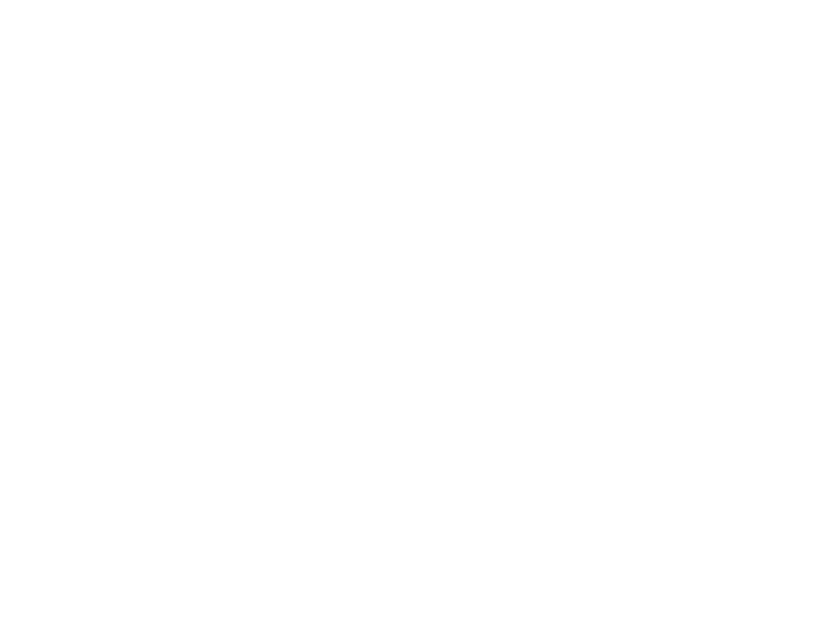

KeyboardInterrupt: 

In [284]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# index_rem = []

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 20 == 0:
        ax.clear()
        
        try:
            for rows in range(num_row_arms):
                # check if any fruit was picked at this time
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
        except IndexError:
            print("** Index grew faster than it should have? **")
            print("Index to remove:", index_rem)
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [285]:
print("List of the fruits that got passed over by vehicle")
print("ROW 0")
print(row_picture[0].passed_fruit)
print("ROW 1")
print(row_picture[1].passed_fruit)
print("ROW 2")
print(row_picture[2].passed_fruit)

List of the fruits that got passed over by vehicle
ROW 0
[72, 84]
ROW 1
[]
ROW 2
[]
